<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/examples/multi_modal/image_to_image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image to Image Retrieval using CLIP embedding and image correlation reasoning using GPT4V

In this notebook, we show how to build a Image to Image retrieval using LlamaIndex with GPT4-V and CLIP.

LlamaIndex Image to Image Retrieval

- Images embedding index: [CLIP](https://github.com/openai/CLIP) embeddings from OpenAI for images


Framework: [LlamaIndex](https://github.com/run-llama/llama_index)

Steps:
1. Download texts, images, pdf raw files from Wikipedia pages

2. Build Multi-Modal index and vetor store for both texts and images

3. Retrieve relevant images given a image query using Multi-Modal Retriever

4. Using GPT4V for reasoning the correlations between the input image and retrieved images

In [ ]:
%pip install git+https://github.com/run-llama/llama_index.git
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client
%pip install wikipedia

  Cloning https://github.com/run-llama/llama_index.git to /tmp/pip-req-build-k6njqz3n
  Running command git clone --filter=blob:none --quiet https://github.com/run-llama/llama_index.git /tmp/pip-req-build-k6njqz3n
  Resolved https://github.com/run-llama/llama_index.git to commit 0c9faae42fd1331a57f2f4c670a60295ab502c21
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00

In [ ]:
import os

OPENAI_API_TOKEN = "sk-..."
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

## Download images and texts from Wikipedia

In [ ]:
import wikipedia
import urllib.request
from pathlib import Path


image_path = Path("mixed_wiki")
image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "Vincent van Gogh",
    "San Francisco",
    "Batman",
    "iPhone",
    "Tesla Model S",
    "BTS band",
]

# create folder for images only
if not image_path.exists():
    Path.mkdir(image_path)


# Download images for wiki pages
# Assign UUID for each image
for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        page_py = wikipedia.page(title)
        list_img_urls = page_py.images
        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + url.split("/")[-1]

                # img_path could be s3 path pointing to the raw image file in the future
                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except Exception as e:
        print(e)
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

Vincent van Gogh
HTTP Error 429: Too many requests. Please comply with the User-Agent policy to get a higher rate limit: https://meta.wikimedia.org/wiki/User-Agent_policy
No images found for Wikipedia page: Vincent van Gogh
San Francisco
HTTP Error 429: Too many requests. Please comply with the User-Agent policy to get a higher rate limit: https://meta.wikimedia.org/wiki/User-Agent_policy
No images found for Wikipedia page: San Francisco
Batman
iPhone
HTTP Error 429: Too many requests. Please comply with the User-Agent policy to get a higher rate limit: https://meta.wikimedia.org/wiki/User-Agent_policy
No images found for Wikipedia page: iPhone
Tesla Model S
HTTP Error 429: Too many requests. Please comply with the User-Agent policy to get a higher rate limit: https://meta.wikimedia.org/wiki/User-Agent_policy
No images found for Wikipedia page: Tesla Model S
BTS band
HTTP Error 429: Too many requests. Please comply with the User-Agent policy to get a higher rate limit: https://meta.wik

### Plot images from Wikipedia

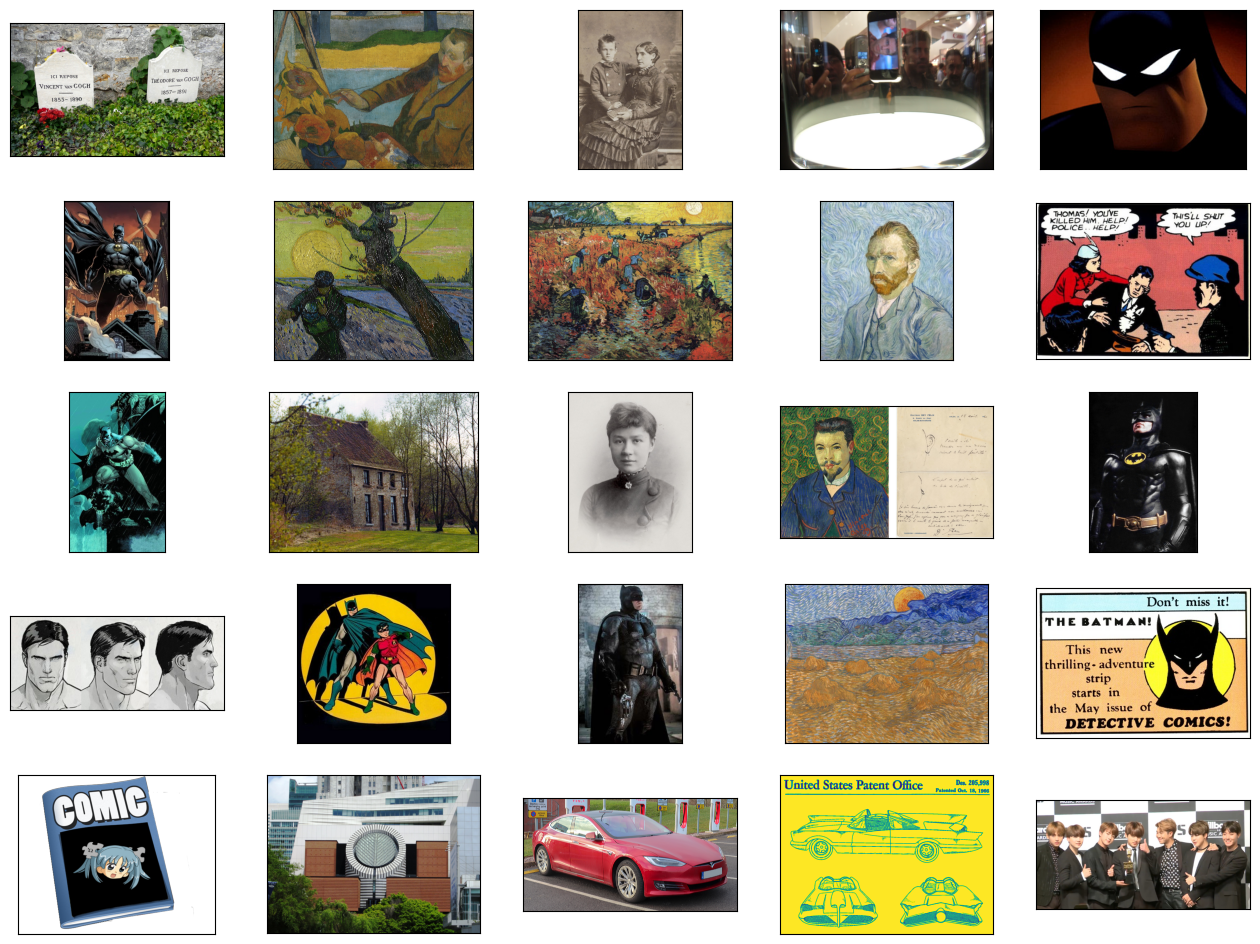

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./mixed_wiki"):
    image_paths.append(str(os.path.join("./mixed_wiki", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 12))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(5, 5, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 25:
                break


plot_images(image_paths)

## Build Multi-Modal index and Vector Store to index both text and images from Wikipedia

In [ ]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_img_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store,image_store=image_store)

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context
)

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.
100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 57.2MiB/s]


## Retrieve images from Multi-Modal Index using an image as the input

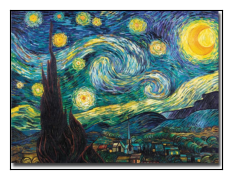

In [ ]:
# Download a copy of Starry Night by Van Gogh
!wget "https://www.dropbox.com/scl/fi/2rqf4z8pfb8v0kw0qvp3b/starry_night.jpg?rlkey=kk83702lzlu0zh0a47lle3h10&dl=0" -O starry_night.jpg -q
input_image = "./starry_night.jpg"
plot_images([input_image])

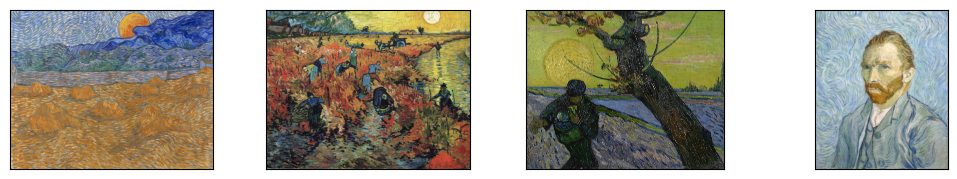

In [ ]:
# instantiate a retriever
retriever_engine = index.as_retriever(image_similarity_top_k=4)
# get images semantically similar to our own
retrieval_results = retriever_engine.image_to_image_retrieve(
    "./starry_night.jpg"
)
retrieved_images = []
for res in retrieval_results:
    retrieved_images.append(res.node.metadata["file_path"])

# display the images we found
plot_images(retrieved_images)

## Query the index using an image and a prompt

In [ ]:
from llama_index.prompts import PromptTemplate
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1500
)

qa_tmpl_str = (
    "Given the images provided, respond to the prompt.\n"
    "Prompt: {query_str}\n"
    "Response: "
)

qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    multi_modal_llm=openai_mm_llm, image_qa_template=qa_tmpl,
    similarity_top_k=3, image_similarity_top_k=3
)

query_str = "Tell me more about paintings like this"
response = query_engine.image_query("./starry_night.jpg", query_str)
print(response)

These paintings exemplify Post-Impressionism, a diverse art movement that emerged as a reaction against Impressionists' concern for the naturalistic depiction of light and color. Post-Impressionist artists sought to convey more emotion and meaning through their work, often focusing on symbolic content, structural composition, and expressing their personal response to a subject.

The distinct brushwork and vibrant, unconventional color choices are characteristic of Post-Impressionism. The artists often used colors to express mood and emotion, rather than to represent the world accurately. They employed thick paint application, and rather than blending to create soft gradations, they often applied color in bold, visible strokes or dots, which can give a painting a dynamic, energetic feel.

One of the most renowned figures associated with Post-Impressionism is Vincent van Gogh, whose work shows a remarkable intensity of color and emotive quality. His technique often involved swirling brus